In [1]:
print("[INFO] loading libraries...")
from libs import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import csv


[INFO] loading libraries...


In [2]:
#Data Pre-processing

#Initialize list of data(images), class labels, target bounding box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

#Load contents of CSV annotations file
with open(config.ANNOTS_PATH + "/train_mnist.csv", 'r') as csvfile:
    rows = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in rows:
        (filename, startX, startY, endX, endY, label) = row 

        #Load image and dimensions
        imagePath = config.IMAGES_PATH + "/" + str(filename)
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        (h, w) = image.shape[:2]

        #Scale coordinates relative to dimensions
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        #Load image and pre process it
        image = img_to_array(image)

        #Update list of data, class labels, bounding box and image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

# convert data into numpy arrays and scale input pixel intensities from 0-255 to 0-1
print("[INFO] converting to numpy arrays...")
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

#Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#Partition data into training and testing  80% train and 20% test
print("[INFO] spliting into train and test data...")
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.2, random_state=42)

#unpack data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

#write testing image paths to disk
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] loading dataset...
[INFO] converting to numpy arrays...
[INFO] spliting into train and test data...
[INFO] saving testing image paths...


In [3]:
#Prepare model

#Create model header based on LeNet architecture
header_net = models.Sequential() 
header_net.add(Conv2D(16, (5, 5),padding="same", activation='relu', input_shape = (128,128,1)))
header_net.add(MaxPooling2D())
header_net.add(Conv2D(32, (5, 5),padding="same", activation='relu'))
header_net.add(MaxPooling2D())
header_net.add(Conv2D(64, (5, 5),padding="same", activation='relu'))
header_net.add(MaxPooling2D())
header_net.add(Conv2D(128, (5, 5),padding="same", activation='relu'))
header_net.add(MaxPooling2D())
header_net.add(Conv2D(256, (5, 5),padding="same", activation='relu'))
header_net.add(MaxPooling2D())


#Flatten the max-pooling output of VGG
flatten = header_net.output
flatten = Flatten()(flatten)

#Create new fully connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name = "bounding_box")(bboxHead)

#Create new fully connected layer header to output the predicted class label
softmaxHead = Dense(120, activation="relu")(flatten)
softmaxHead = Dense(84, activation="relu")(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

#Put together the model which accepts an input image and outputs bounding box coordinates and class label
model = Model(
    inputs = header_net.input, 
    outputs = (bboxHead, softmaxHead))

#Define losses
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

#Define weights per loss
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

#Initialize the optimizer
opt = Adam(lr=config.INIT_LR)

#Compile model
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 416         conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   12832       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [4]:
#Train model

#Construct target training outputs dictionary
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

#Construct target testing outputs dictionary
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

#Train the network for bounding box regression and class label prediction
print("[INFO] training model...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size = config.BATCH_SIZE,
    epochs = config.NUM_EPOCHS,
    verbose=1
)

#Serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH,save_format="h5")

#Serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(config.LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/20
250/250 [==============================] - 71s 286ms/step - loss: 2.2758 - bounding_box_loss: 0.0118 - class_label_loss: 2.2640 - bounding_box_accuracy: 0.8955 - class_label_accuracy: 0.1236 - val_loss: 2.0830 - val_bounding_box_loss: 0.0047 - val_class_label_loss: 2.0783 - val_bounding_box_accuracy: 0.9630 - val_class_label_accuracy: 0.2005
Epoch 2/20
250/250 [==============================] - 72s 288ms/step - loss: 1.7781 - bounding_box_loss: 0.0017 - class_label_loss: 1.7764 - bounding_box_accuracy: 0.9567 - class_label_accuracy: 0.3045 - val_loss: 1.5911 - val_bounding_box_loss: 0.0013 - val_class_label_loss: 1.5898 - val_bounding_box_accuracy: 0.9760 - val_class_label_accuracy: 0.3450
Epoch 3/20
250/250 [==============================] - 72s 287ms/step - loss: 1.4999 - bounding_box_loss: 0.0012 - class_label_loss: 1.4987 - bounding_box_accuracy: 0.9640 - class_label_accuracy: 0.4256 - val_loss: 1.3020 - val_bounding_box_loss: 0.0012 - val_class_

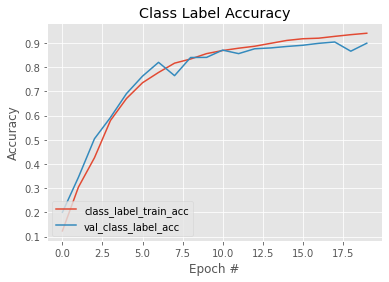

In [5]:
#Results

#Plot total loss, label loss and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize = (13,13))

#Loop over the loss names
for (i, l) in enumerate(lossNames):
    #plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if 1 != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

#Save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([config.PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()

#Create new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
    label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
    label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

#Save the accuracies plot
plotPath = os.path.sep.join([config.PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)
